In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import dblquad
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta
%matplotlib inline

In [177]:
lat_min, lat_max = 31.1, 31.4
lon_min, lon_max = 121.3, 121.8
lat_ctr = (int)((lat_max - lat_min) / 0.005)
lon_ctr = (int)((lon_max - lon_min) / 0.005)

def lat_quantize(lat):
    return (int)((lat - lat_min) / 0.005)
def lon_quantize(lon):
    return (int)((lon - lon_min) / 0.005)

In [178]:
data = pd.read_csv("./data/rcar/BOT_data_rcar_20170102_20170102_part0.csv")
data = data[(data['lat'] > 0.1) & (data['lon'] > 0.1)]
data["date_time"] = data["date_time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [4]:
def integrate_density(density):
    for col in range(1,density.shape[1]):
        density[0][col] += density[0][col-1];
    for row in range(1,density.shape[0]):
        density[row][0] += density[row-1][0]
        for col in range(1,density.shape[1]):
            density[row][col] += (density[row][col-1] 
                                + density[row-1][col] 
                                - density[row-1][col-1]);
                
    return density

In [179]:
def extract_hist(data):
    # if there is only one car, code will throw error
    if data.shape[0] < 2:
        return
    
    hist, xedges, yedges = np.histogram2d(data['lat'], data['lon'],
        bins = [range(lat_ctr),
                range(lon_ctr)],
        range=[[0, lat_ctr],
               [0, lon_ctr]])
    #hist = integrate_density(hist)
    #xpos, ypos = np.meshgrid(xedges[1:], yedges[1:])
    #X = np.stack((xpos.flatten(), ypos.flatten()), axis=1)
    #y = hist.flatten()
    #return X, y
    return hist

/home/jachinshen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jachinshen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


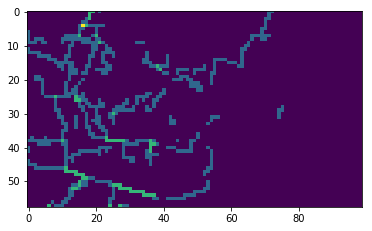

In [180]:
def get_density_hour(data, hour_begin, hour_end):
    data_hour = data[(hour_begin <= data['date_time']) & (data['date_time'] < hour_end)]
    data_hour['lat'] = data_hour['lat'].apply(lambda lat:
        (int)((lat-lat_min) / 0.005))
    data_hour['lon'] = data_hour['lon'].apply(lambda lon:
        (int)((lon-lon_min) / 0.005))
    data_hour = data_hour.drop_duplicates(['car_id', 'lat', 'lon'])
    hist  = extract_hist(data_hour)
    '''
    fig = plt.figure(figsize=(12, 8))
    ax = fig.gca(projection='3d')
    
    ax.plot_surface(xpos, ypos, hist, cmap=cm.coolwarm, 
                    linewidth=0, antialiased=False)
    ax.set_xlabel("lat")
    ax.set_ylabel("lon")
    #ax.set_zlim(0, 2000)
    fig.suptitle("{} to {}".format(hour_begin, hour_end))
    plt.show()
    '''
    return hist

hist = get_density_hour(data, datetime(2017, 1, 2, 13), datetime(2017, 1, 2, 14))
plt.imshow(hist)
plt.show()

In [181]:
def get_range_density(hist, range_xy):
    #center_lat = lat_quantize((range_xy[0][0] + range_xy[0][1]) / 2)
    #center_lon = lon_quantize((range_xy[1][0] + range_xy[1][1]) / 2)
    center_lat = lat_quantize(range_xy[0][0])
    center_lon = lon_quantize(range_xy[1][0])
    return hist[center_lat][center_lon]
print(get_range_density(hist, [[31.31, 31.315], [121.790, 121.795]]))

0.0


In [182]:
X_sub['car_number'] = X_sub.apply(
        lambda row: get_range_density(hist,
            [row['latitude_range'], row['longitude_range']]), axis=1)

In [167]:
def convert_str_range(string):
    string_split = string.split('~')
    return list(map(float, string_split))
def get_submission_range():
    X_sub = pd.read_csv("./A-test.csv")
    X_sub['latitude_range'] = X_sub['latitude_range'].apply(convert_str_range)
    X_sub['longitude_range'] = X_sub['longitude_range'].apply(convert_str_range)
    return X_sub
X_sub = get_submission_range()

In [192]:
def get_dataset():
    frames = []
    features_need = ['car_id', 'date_time', 'lat', 'lon']
    rcar_dtype = {'car_id': str,
                  'date_time': str,
                  'lat': float,
                  'lon': float,
                  'power_mode': str,
                  'mileage': float,
                  'speed': float,
                  'fuel_consumption': float}
    ecar_dtype = {'car_id': str,
                  'date_time': str,
                  'lat': float,
                  'lon': float,
                  'work_mode': str,
                  'mileage': float,
                  'speed': float,
                  'avg_fuel_consumption': float,
                  'system_mode': str}
    for part in range(3):
        filename = ("./data/rcar/BOT_data_rcar_20170306_20170306_part{}.csv"
                    .format(part))
        data_part = pd.read_csv(filename, dtype=rcar_dtype)[features_need]
        data_part = data_part[(data_part['lat'] > 0.1) & (data_part['lon'] > 0.1)]
        frames.append(data_part)
        
        filename = ("./data/ecar/BOT_data_ecar_20170306_20170306_part{}.csv"
                    .format(part))
        data_part = pd.read_csv(filename, dtype={'system_mode': str})[features_need]
        data_part = data_part[(data_part['lat'] > 0.1) & (data_part['lon'] > 0.1)]
        frames.append(data_part)
        
    data = pd.concat(frames)
    data["date_time"] = data["date_time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    return data

In [197]:
def unit_1(hour):
    data = get_dataset()
    hist = get_density_hour(data, datetime(2017, 1, 2, hour),
                           datetime(2017, 1, 2, hour+1))
    return hist
hist = unit_1(9)

In [194]:
def train_hour_baseline(hour):
    data = get_dataset()
    hist = get_density_hour(data, datetime(2017, 1, 2, hour),
                           datetime(2017, 1, 2, hour+1))
    #plt.imshow(hist)
    #plt.show()
    X_sub['car_number'] = X_sub.apply(
        lambda row: get_range_density(hist,
            [row['latitude_range'], row['longitude_range']]), axis=1)
    
    
train_hour_baseline(9)

TypeError: ("'NoneType' object is not subscriptable", 'occurred at index 0')

In [195]:
X_sub

,grid_id,latitude_range,longitude_range,car_number
0,1,"[31.195, 31.2]","[121.315, 121.32]",13.0
1,2,"[31.22, 31.225]","[121.355, 121.36]",8.0
2,3,"[31.26, 31.265]","[121.485, 121.49]",4.0
3,4,"[31.15, 31.155]","[121.51, 121.515]",2.0
4,5,"[31.19, 31.195]","[121.77, 121.775]",3.0
5,6,"[31.23, 31.235]","[121.37, 121.375]",11.0
6,7,"[31.22, 31.225]","[121.41, 121.415]",15.0
7,8,"[31.15, 31.155]","[121.48, 121.485]",6.0
8,9,"[31.265, 31.27]","[121.485, 121.49]",4.0
9,10,"[31.205, 31.21]","[121.55, 121.555]",2.0
